### Import packages and Define utility functions

In [1]:
import numpy as np
import torch 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

### Load data from previous step  

In [2]:
# Read CSV file into a pandas DataFrame
df_dedup_2 = pd.read_csv('df_dedup_2.csv', converters={'id': str, 
                                                         'member_id': str})    
df_dedup_2.head()

,id,member_id,loan_amnt,emp_length,home_ownership,annual_inc,desc,purpose,percent_bc_gt_75,bc_util,...,mths_since_recent_inq,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,internal_score,bad_flag,term_nb,int_rate_nb,revol_util_nb
0,10000001,11983056,7550,3 years,RENT,28000.0,NaN,debt_consolidation,100.0,96.0,...,17.0,4000.0,NaN,3828.953801,5759.0,99,0.0,36.0,0.1624,0.720
1,10000002,12002921,27050,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,25.0,53.9,...,8.0,35700.0,NaN,34359.940730,114834.0,353,0.0,36.0,0.1099,0.612
2,10000003,11983096,12000,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,0.0,15.9,...,3.0,18100.0,NaN,16416.617760,7137.0,157,0.0,36.0,0.1099,0.240
3,10000004,12003142,28000,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,16.7,67.1,...,3.0,42200.0,NaN,38014.149760,799592.0,365,0.0,36.0,0.0762,0.546
4,10000005,11993233,12000,10+ years,RENT,40000.0,NaN,debt_consolidation,33.3,79.6,...,17.0,7000.0,53.0,6471.462236,13605.0,157,0.0,36.0,0.1353,0.688


In [3]:
df.dtypes

NameError: name 'df' is not defined

In [ ]:
# "term" should be numeric
df.term.value_counts()

In [ ]:
# fix "term"
df['term_nb'] = np.where(df['term'].notnull() & ~df['term'].isna(), 
                         pd.to_numeric(df['term'].str[0:3], errors='coerce'), 
                         np.nan
                        )
df.term_nb.dtype, df.term_nb.value_counts()

In [ ]:
# "int_rate", "revol_util" should be float. They are read in as characters due to the "%".
df['int_rate'].value_counts(), df['revol_util'].value_counts() 

In [ ]:
# fix "int_rate", "revol_util"
df['int_rate_nb'] = df['int_rate'].str.rstrip('%').astype('float') / 100.0
df['revol_util_nb'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0
df['int_rate_nb'].dtype, df['int_rate_nb'][0: 5], df['revol_util_nb'].dtype, df['revol_util_nb'][0: 5]

In [ ]:
# "emp_length" could be numeric or character depending on the data. Let's take a look first.
df['emp_length'].value_counts()

In [ ]:
# no need to fix at this moment. In the modeling phase, values need to be encoded and/or binned then encoded.

In [ ]:
# duplicate rows
def rm_dup_rows(df_in):
    df = df_in.copy()
    dup_count = len(df) - len(df.drop_duplicates())
    print(f"There are no duplicate records. - {dup_count == 0}")
    
    if not len(df) == len(df.drop_duplicates()):
        df.drop_duplicates(inplace=True)
        print(f"{dup_count} of duplicate records were removed.")
    else:
        print("No duplicate rows detected.")
    print(f"The dataset has {len(df)} rows.")
    return df

df_dedup = rm_dup_rows(df)

In [ ]:
# duplicate IDs - "True" tells that values in columns "id" are all unique, which is as expected.
df_dedup.id.nunique() == len(df_dedup) 

In [ ]:
# "application_approved_flag" could be useless because all records should be approved loans. to confirm:
df_dedup['application_approved_flag'].value_counts()

In [ ]:
# drop column "application_approved_flag", "term", "int_rate", "revol_util"
df_dedup.drop(['application_approved_flag', "term", "int_rate", "revol_util"], axis=1, inplace=True)

In [ ]:
df_dedup.describe()

In [ ]:
(df_dedup.describe().loc['count'] - len(df_dedup)) / len(df_dedup)

In [ ]:
df_dedup_2 = df_dedup.loc[df_dedup['bad_flag'].notnull()].copy()
df_dedup_2.describe()

In [ ]:
# 'bad_flag'
df_dedup_2['bad_flag'].value_counts(), df_dedup_2['bad_flag'].sum() / len(df_dedup_2['bad_flag'])

In [ ]:
create_box_plot(df_dedup_2)

### 3. Explore the dataset, Investigate and fix missing values and outliers
Findings / Summary:

* Missing cells in "emp_length" are filled with 'NONE' as a string. Since "home_ownership" already has 'NONE', there is no need to change.
* Some missing values are related. Finding additional data may be helpful to fill the values.
* Since this is just a demonstrative project, along with the constraints in data and timing, I just use 2 examples to illustrate the investigation process, and will use a simple approach to fix the missing value issue in the following steps. There is no one-size-fits-all solution in dealing with missing values and outliers.
* non-numeric missing values are filled with 'NONE' as a string, while numeric ones with the mean of each variable respectively.

#### 3.1 Outliers
Findings / Summary:
* Define outliers as data points that are out of the range of (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR), where IQR stands for Interquartile range; Q1 refers to first quartile; Q3 refers to the third quartile.
* Recall that "annual_inc", "bc_util", "revol_util_nb", "inq_last_6mths", "total_bc_limit", "mths_sinc_last_major_derog", "tot_hi_cre_lim", "total_cur_bal" have outliers telling from the box plots above.
* The boxplot and histgram suggest that majority of 'annual_inc' concentrate within the $87k (3-rd quantile), 7501 outliers and only 17 over $1M.
* There is no evidence to support that outliers in 'annual_inc' are invalid. Thus, they will stay in the dataset for further analysis.
* For utilization variables, out of range (> 100%) values are capped at 100%.
* "inq_last_6mths" boxplot suggests outliers statistically. However, it makes sense that majority of borrowers do not have any credit inquiry in the past 6 months. Thus, there is no data issue in this column.
* There is not sufficient evidence to prove that any other outliers are due incorrect data. Thus they will be carried on for further analysis.

In [4]:
def dynamic_boxplot(series):
    def update_plot(max_val):
        filtered_series = series[(series <= max_val)]
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=filtered_series)
        plt.show()

    min_val = series.min()
    max_val = series.max()

    slider = widgets.FloatRangeSlider(
        value=[min_val, max_val],
        # min=min_val,
        max=max_val,
        step=1000,
        description='Range:',
        continuous_update=False
    )

    interactive_plot = widgets.interactive(update_plot,  max_val=slider.value[1])
    display(interactive_plot)
    
dynamic_boxplot(df_dedup_2['annual_inc'].dropna())

interactive(children=(FloatSlider(value=7141778.0, description='max_val', max=21425334.0, min=-7141778.0), Out…

(array([1.24592e+05, 5.44110e+04, 6.84500e+03, 1.39700e+03, 4.69000e+02,
        1.64000e+02, 1.00000e+02, 3.50000e+01, 3.10000e+01, 1.80000e+01,
        1.10000e+01, 1.20000e+01, 7.00000e+00, 1.40000e+01, 1.00000e+00,
        0.00000e+00, 4.00000e+00, 3.00000e+00, 2.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

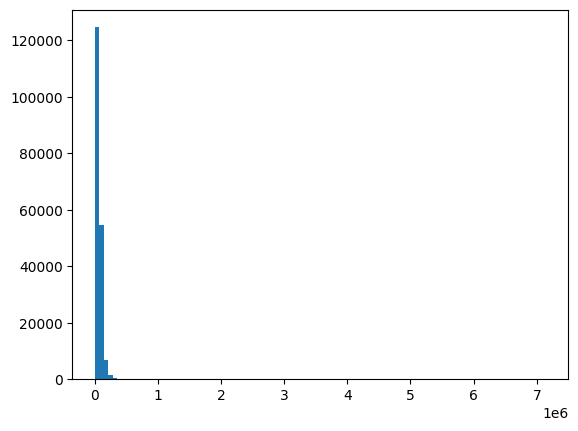

In [5]:
plt.hist(df_dedup_2['annual_inc'], bins=100)

In [6]:
IQR = df_dedup_2['annual_inc'].quantile(0.75) - df_dedup_2['annual_inc'].quantile(0.25)
upper_band = df_dedup_2['annual_inc'].quantile(0.75) + 1.5 * IQR
print(f"There are {sum(df_dedup_2['annual_inc'] > upper_band)} of outliers in 'annual_inc'. ")
print(f"# of $1M + {sum(df_dedup_2['annual_inc'] > 1000000)}")

There are 7501 of outliers in 'annual_inc'. 
# of $1M + 17


In [7]:
# Be definition, utilization variables including 'bc_util' and 'revol_util_nb' should indicate a percentage between 0 and 100%.
print(f"# of records where 'bc_util' or 'revol_util_nb' is out of boundary is {sum(df_dedup_2['bc_util'] > 100), sum(df_dedup_2['revol_util_nb'] > 1)}, respectively.")

# of records where 'bc_util' or 'revol_util_nb' is out of boundary is (3503, 256), respectively.


In [8]:
# Fix utilization rate
df_dedup_2['bc_util_fixed'] = np.where(df_dedup_2['bc_util'] > 100, 100, df_dedup_2['bc_util'])
df_dedup_2['revol_util_nb_fixed'] = np.where(df_dedup_2['revol_util_nb'] > 1, 100, df_dedup_2['bc_util'] * 100)

#### 3.2 Missing Values
Findings / Summary:
* Since this is just a demonstrative project, along with the constraints in data and timing, I just use 2 examples to illustrate the investigation process, and will use a simple approach to fix the missing value issue in the following steps. There is no one-size-fits-all solution in dealing with missing values and outliers.
* non-numeric missing values are filled with 'NONE' as a string, while numeric ones with the mean of each variable respectively.

In [9]:
# remind myself of variables having missing values, and the distributions among event v.s non-event
for c in df_dedup_2.columns:
    if df_dedup_2[c].isnull().sum() > 0:
        print(c, df_dedup_2.loc[df_dedup_2[c].isnull(), 'bad_flag'].value_counts())

emp_length bad_flag
0.0    7220
1.0     657
Name: count, dtype: int64
desc bad_flag
0.0    99887
1.0     6775
Name: count, dtype: int64
percent_bc_gt_75 bad_flag
0.0    7820
1.0    1207
Name: count, dtype: int64
bc_util bad_flag
0.0    7894
1.0    1217
Name: count, dtype: int64
mths_since_recent_inq bad_flag
0.0    25802
1.0     2058
Name: count, dtype: int64
total_bc_limit bad_flag
0.0    6447
1.0    1048
Name: count, dtype: int64
mths_since_last_major_derog bad_flag
0.0    144449
1.0     11177
Name: count, dtype: int64
tot_hi_cred_lim bad_flag
0.0    6447
1.0    1048
Name: count, dtype: int64
tot_cur_bal bad_flag
0.0    24000
1.0     3741
Name: count, dtype: int64
revol_util_nb bad_flag
0.0    111
1.0     14
Name: count, dtype: int64
bc_util_fixed bad_flag
0.0    7894
1.0    1217
Name: count, dtype: int64
revol_util_nb_fixed bad_flag
0.0    7881
1.0    1216
Name: count, dtype: int64


In [10]:
# Fill Missing values in "emp_length" with 'NONE' as a string
df_dedup_2['emp_length'] = df_dedup_2['emp_length'].fillna('NONE')
df_dedup_2['emp_length'].value_counts()

emp_length
10+ years    61175
2 years      16143
5 years      14265
3 years      13965
< 1 year     13222
6 years      11916
1 year       11434
7 years      11207
4 years      10846
8 years       8950
NONE          7877
9 years       7123
Name: count, dtype: int64

In [11]:
# Fill missing values of numeric variables with their corresponding mean
c_lst = ['percent_bc_gt_75', 'bc_util_fixed', 'mths_since_recent_inq', 'total_bc_limit', 'mths_since_last_major_derog', 'tot_hi_cred_lim', 'tot_cur_bal', 'revol_util_nb_fixed']
## create a new dataframe to house the cleaned data
carry_cols = [c for c in df_dedup_2.columns if (c not in c_lst) & (c not in ['bc_util', 'revol_util_nb'])]
df_clean = df_dedup_2[carry_cols].copy()

for c in c_lst:
    print(f"Missing values in '{c}' is imputed by its mean.")
    df_clean[c] = df_dedup_2[c].fillna(df_dedup_2[c].mean())

Missing values in 'percent_bc_gt_75' is imputed by its mean.
Missing values in 'bc_util_fixed' is imputed by its mean.
Missing values in 'mths_since_recent_inq' is imputed by its mean.
Missing values in 'total_bc_limit' is imputed by its mean.
Missing values in 'mths_since_last_major_derog' is imputed by its mean.
Missing values in 'tot_hi_cred_lim' is imputed by its mean.
Missing values in 'tot_cur_bal' is imputed by its mean.
Missing values in 'revol_util_nb_fixed' is imputed by its mean.


#### 3.3 Re-examination
Summary:
* There are no duplicate rows, redundant or unnecessary columns in the dataset. 
* There are no missing values, outliers proven to be incorrect.


In [12]:
df_clean.describe()

,loan_amnt,annual_inc,dti,inq_last_6mths,internal_score,bad_flag,term_nb,int_rate_nb,percent_bc_gt_75,bc_util_fixed,mths_since_recent_inq,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,revol_util_nb_fixed
count,188123.000000,1.881230e+05,188123.000000,188123.000000,188123.000000,188123.000000,188123.000000,188123.000000,188123.000000,188123.000000,188123.000000,188123.000000,188123.000000,188123.000000,1.881230e+05,188123.000000
mean,14354.545962,7.223871e+04,17.058663,0.803581,187.641288,0.069784,41.648177,0.142791,53.557030,66.781167,6.991770,20240.250448,41.792473,20239.458973,1.373305e+05,6668.776100
std,8115.066458,5.182946e+04,7.596977,1.032841,105.482445,0.254784,10.181105,0.044369,33.319088,25.394864,5.427686,18505.203989,8.727016,18565.824720,1.391999e+05,2555.118696
min,1000.000000,4.800000e+03,0.000000,0.000000,14.000000,0.000000,36.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,8000.000000,4.500000e+04,11.340000,0.000000,105.000000,0.000000,36.000000,0.111400,28.600000,50.900000,3.000000,8100.000000,41.792473,8073.829420,3.203900e+04,5080.000000
50%,12175.000000,6.200000e+04,16.780000,0.000000,159.000000,0.000000,36.000000,0.140900,53.557030,70.300000,6.991770,15400.000000,41.792473,15331.985240,1.268950e+05,7020.000000
75%,20000.000000,8.700000e+04,22.580000,1.000000,261.000000,0.000000,36.000000,0.172700,80.000000,88.300000,9.000000,25700.000000,41.792473,25692.260360,1.854125e+05,8820.000000
max,35000.000000,7.141778e+06,34.990000,8.000000,456.000000,1.000000,60.000000,0.260600,100.000000,100.000000,24.000000,522210.000000,165.000000,520643.298200,8.000078e+06,33960.000000


In [13]:
character_columns = df_clean.select_dtypes(include='object').columns
for c in character_columns:
    print(f"# of Missing values in {c}: {df_clean[c].isnull().sum() / 1}")

# of Missing values in id: 0.0
# of Missing values in member_id: 0.0
# of Missing values in emp_length: 0.0
# of Missing values in home_ownership: 0.0
# of Missing values in desc: 106662.0
# of Missing values in purpose: 0.0


In [14]:
# Create log transformation
def create_log_var(data, vars):
    df = data.copy()
    for v in vars:
        df[v + '_log'] = np.where(df[v] > 0, np.log(df[v]), 0)
        print(f"Created {v}_log")
    return df

vars = ['loan_amnt', 'annual_inc', 'total_bc_limit', 'tot_hi_cred_lim', 'tot_cur_bal']
df_clean = create_log_var(df_clean, vars)

Created loan_amnt_log
Created annual_inc_log
Created total_bc_limit_log
Created tot_hi_cred_lim_log
Created tot_cur_bal_log


c:\users\lywon\projects\hw_ccf\.venv2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\lywon\projects\hw_ccf\.venv2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\lywon\projects\hw_ccf\.venv2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
incl_cols = [ 
       'dti', 'inq_last_6mths',
       'internal_score', 'bad_flag', 'term_nb', 'int_rate_nb',
       'percent_bc_gt_75', 'bc_util_fixed', 'mths_since_recent_inq',
       'mths_since_last_major_derog', 
       'revol_util_nb_fixed', 'loan_amnt_log', 'annual_inc_log',
       'total_bc_limit_log', 'tot_hi_cred_lim_log', 'tot_cur_bal_log']

corr = df_clean[incl_cols].corr()
corr.style.background_gradient(cmap='coolwarm')

,dti,inq_last_6mths,internal_score,bad_flag,term_nb,int_rate_nb,percent_bc_gt_75,bc_util_fixed,mths_since_recent_inq,mths_since_last_major_derog,revol_util_nb_fixed,loan_amnt_log,annual_inc_log,total_bc_limit_log,tot_hi_cred_lim_log,tot_cur_bal_log
dti,1.000000,0.011619,0.044566,0.039879,0.083453,0.147578,0.188125,0.206684,0.000952,0.019239,0.205469,0.051405,-0.216860,0.049501,0.049566,0.122158
inq_last_6mths,0.011619,1.000000,0.019807,0.059380,0.040899,0.241492,-0.078224,-0.081261,-0.640133,-0.002095,-0.079205,0.008902,0.104708,-0.003537,-0.003458,0.097641
internal_score,0.044566,0.019807,1.000000,0.009110,0.440817,0.182788,0.007224,0.041243,-0.000088,-0.031756,0.039973,0.927234,0.502930,0.312313,0.312193,0.305679
bad_flag,0.039879,0.059380,0.009110,1.000000,0.038482,0.121427,0.046743,0.040724,-0.048175,-0.001033,0.040352,0.004951,-0.059127,-0.042862,-0.042741,-0.011728
term_nb,0.083453,0.040899,0.440817,0.038482,1.000000,0.461320,0.046341,0.051665,-0.024888,-0.013298,0.050118,0.407910,0.150314,0.081777,0.081733,0.151345
int_rate_nb,0.147578,0.241492,0.182788,0.121427,0.461320,1.000000,0.353777,0.374629,-0.209500,-0.004483,0.368633,0.112633,-0.035387,-0.217238,-0.216865,-0.134533
percent_bc_gt_75,0.188125,-0.078224,0.007224,0.046743,0.046341,0.353777,1.000000,0.831549,0.055076,0.016368,0.822065,0.005730,-0.041244,-0.151893,-0.151789,0.024298
bc_util_fixed,0.206684,-0.081261,0.041243,0.040724,0.051665,0.374629,0.831549,1.000000,0.054730,0.013673,0.989724,0.044091,-0.013224,-0.163088,-0.162952,0.042758
mths_since_recent_inq,0.000952,-0.640133,-0.000088,-0.048175,-0.024888,-0.209500,0.055076,0.054730,1.000000,-0.000422,0.052566,0.007635,-0.059670,0.012973,0.012780,-0.060734
mths_since_last_major_derog,0.019239,-0.002095,-0.031756,-0.001033,-0.013298,-0.004483,0.016368,0.013673,-0.000422,1.000000,0.013713,-0.027689,-0.045252,-0.005383,-0.005333,-0.037192


### Output cleaned dataset for next step

In [16]:
df_clean.to_csv('df_clean.csv', index=False)